# <div style="color: green">[Scripts] Détecter les bad buzz - comparaison des modèles</div>

<img src="img/flight_logo.png">

<div class='alert alert-block alert-warning'>
    
Pour des raisons pratiques (notamment l'utilisation d'une accélération matérielle), le présent notebook a été exécuté sur Google Collab.<br>
Il se peut que des messages d'alerte apparaissent lors de la consultation de ce notebook sur d'autres systèmes (comme par exemple Jupyter).
    
</div>

# <div id="ch0" style="color: blue">0. Plan du notebook</div>

1. [Installation et imports](#ch1)<br>
2. [Mise en forme des jeux de données](#ch2)<br>
3. [Réseaux de neurones Keras](#ch3)<br>
>3.1 [Keras : Modèle complètement connecté](#ch3_1)<br>
>3.2 [Keras : Modèle convolutionnel](#ch3_2)<br>
>3.3 [Keras : LSTM](#ch3_3)<br>
>3.4 [Keras : LSTM bidirectionnel](#ch3_4)<br>
>3.5 [Keras : GRU bidirectionnel](#ch3_5)<br>
>3.6 [Keras : LSTM bidirectionnel & word embedding pré-entraîné (GloVe)](#ch3_6)<br>
>3.7 [Keras : LSTM bidirectionnel & word embedding pré-entraîné (FastText)](#ch3_7)<br>
>3.8 [Keras : LSTM bidirectionnel & word embedding pré-entraîné (GloVe) - sans normalisation](#ch3_8)<br>
4. [Transformers BERT](#ch4)<br>
>4.1 [BERT : DistilBERT](#ch4_1)<br>
>4.2 [BERT : BERTweet](#ch4_2)<br>

# <div id="ch1" style="color:blue">1. Installation et Imports</div>

In [1]:
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("500")')

In [2]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install nltk
%pip install contractions
%pip install scikit-learn
%pip install gensim
%pip install keras
%pip install tensorflow
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 6.6 MB/s 
     |████████████████████████████████| 106 kB 97.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [18]:
import gc
import os
import re
import sys
import time
import gensim
import string
import chardet
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib
import joblib
import contractions
from urllib.error import HTTPError
from urllib.parse import quote
from urllib.parse import urlencode
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import one_hot
from keras_preprocessing import sequence
from keras_preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.models import save_model
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import LSTM
from keras.layers import GRU

In [6]:
from keras import metrics

In [7]:
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [8]:
from numpy.random import seed

In [9]:
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
import nltk
from nltk.stem import WordNetLemmatizer
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [14]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

*[(Retour sommaire)](#ch0)*

# <div id="ch2" style="color:blue">2. Mise en forme des jeux de données</div>

In [20]:
tw_en = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data/tw_normalized.csv')

In [21]:
tw_en['tw_y'].replace(to_replace=4, value=1, inplace=True)

In [22]:
tw_en = tw_en[tw_en['normalized'].str.len() > 1]

In [23]:
print(f"Taille du jeu de données des séquences normalisées > 1 : {tw_en.shape[0]}")

Taille du jeu de données des séquences normalisées > 1 : 1514604


In [24]:
nb_pos = tw_en[tw_en['tw_y'] == 1].shape[0]
nb_neg = tw_en[tw_en['tw_y'] == 0].shape[0]
print(f"Nombre de lignes par classe : POS = {nb_pos} lignes :: NEG = {nb_neg} lignes")
print(f"Différence : {np.abs(nb_pos - nb_neg)} lignes en plus pour la classe {'POS' if nb_pos > nb_neg else 'NEG'}")

Nombre de lignes par classe : POS = 753885 lignes :: NEG = 760719 lignes
Différence : 6834 lignes en plus pour la classe NEG


In [25]:
tw_pos = tw_en.loc[tw_en['tw_y'] == 1, ['normalized', 'tw_y']]
tw_neg = tw_en.loc[tw_en['tw_y'] == 0, ['normalized', 'tw_y']]
tw_pos_train = tw_pos.head(680000)
tw_pos_test = tw_pos.tail(tw_pos.shape[0] - 680000)
tw_neg_train = tw_neg.head(680000)
tw_neg_test = tw_neg.tail(tw_neg.shape[0] - (680000))
X_train = np.concatenate((tw_pos_train['normalized'], tw_neg_train['normalized']))
X_test = np.concatenate((tw_pos_test['normalized'], tw_neg_test['normalized']))
y_train = np.concatenate((tw_pos_train['tw_y'], tw_neg_train['tw_y']))
y_test = np.concatenate((tw_pos_test['tw_y'], tw_neg_test['tw_y']))

In [26]:
print(f"Taille du jeu d'entraînement : X={np.shape(X_train)} y={np.shape(y_train)}")
print(f"Taille du jeu de test : X={np.shape(X_test)} y={np.shape(y_test)}")

Taille du jeu d'entraînement : X=(1360000,) y=(1360000,)
Taille du jeu de test : X=(154604,) y=(154604,)


In [27]:
MAX_LEN = tw_en['lng'].max()  #Taille maximale des tweets du dataset
TOP_WORDS = 40000  #Taille du vocabulaire trouvée au chapitre précédent

In [28]:
MAX_LEN

50

In [29]:
tokenizer = Tokenizer(num_words=TOP_WORDS)
tokenizer.fit_on_texts(X_train)

In [89]:
import pickle
with open('/content/gdrive/MyDrive/Colab Notebooks/data/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=MAX_LEN)
    return padded

In [31]:
X_train_padded = get_sequences(tokenizer, X_train)
X_test_padded = get_sequences(tokenizer, X_test)

In [32]:
EMBEDDING_VECTOR_LENGTH = 256

*[(Retour sommaire)](#ch0)*

# <div id="ch3" style="color:blue">3. Réseaux de neurones Keras</div>

In [33]:
def plot_keras_results(h, model, X_test, y_test):
    print('Métriques')
    print('---------')
    epochs = range(1, len(h['accuracy']) + 1)
    plt.figure(figsize=(15, 8))
    #Recall
    plt.subplot(2, 2, 1)
    plt.plot(epochs, h['recall'], '-', label='Training Recall')
    plt.plot(epochs, h['val_recall'], ':', label='Validation Recall')
    plt.title('Training and Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(loc='upper left')
    #Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, h['accuracy'], '-', label='Training Accuracy')
    plt.plot(epochs, h['val_accuracy'], ':', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    #TN
    plt.subplot(2, 2, 3)
    plt.plot(epochs, h['true_negatives'], '-', label='Training TN')
    plt.plot(epochs, h['val_true_negatives'], ':', label='Validation TN')
    plt.title('Training and Validation True Negative')
    plt.xlabel('Epoch')
    plt.ylabel('True Negative')
    plt.legend(loc='upper left')
    #Loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, h['loss'], '-', label='Training Loss')
    plt.plot(epochs, h['val_loss'], ':', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()
    print()
    y_pred = np.rint(model.predict(X_test))
    print('Matrice de confusion')
    print('--------------------')
    print(confusion_matrix(y_test, y_pred))
    print()
    print('Scores')
    print('--------------------')
    print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
    print(f"Recall : {recall_score(y_test, y_pred)}")
    print(f"AUC : {roc_auc_score(y_test, y_pred)}")

## <div id="ch3_1" style="color:orange">3.1 Keras : Modèle complètement connecté</div>

In [34]:
rec = metrics.Recall()
tn = metrics.TrueNegatives()

In [35]:
k_spl = Sequential()
k_spl.add(Embedding(TOP_WORDS, EMBEDDING_VECTOR_LENGTH, input_length=MAX_LEN))
k_spl.add(Flatten())
k_spl.add(Dense(16, activation='relu'))
k_spl.add(Dense(1, activation='sigmoid'))
k_spl.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [36]:
k_spl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 256)           10240000  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 16)                204816    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10,444,833
Trainable params: 10,444,833
Non-trainable params: 0
_________________________________________________________________


In [37]:
tps1 = time.time()
hist_spl = k_spl.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_spl.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 65s 6ms/step - loss: 0.4747 - accuracy: 0.7714 - recall: 0.7731 - true_negatives: 523334.0000 - val_loss: 0.4753 - val_accuracy: 0.7722 - val_recall: 0.7722 - val_true_negatives: 62337.0000
Epoch 2/5
10625/10625 [==============================] - 61s 6ms/step - loss: 0.4349 - accuracy: 0.7948 - recall: 0.7932 - true_negatives: 541606.0000 - val_loss: 0.4799 - val_accuracy: 0.7718 - val_recall: 0.7377 - val_true_negatives: 64821.0000
Epoch 3/5
10625/10625 [==============================] - 61s 6ms/step - loss: 0.3956 - accuracy: 0.8163 - recall: 0.8122 - true_negatives: 557920.0000 - val_loss: 0.5101 - val_accuracy: 0.7661 - val_recall: 0.7654 - val_true_negatives: 61895.0000


Métriques
---------


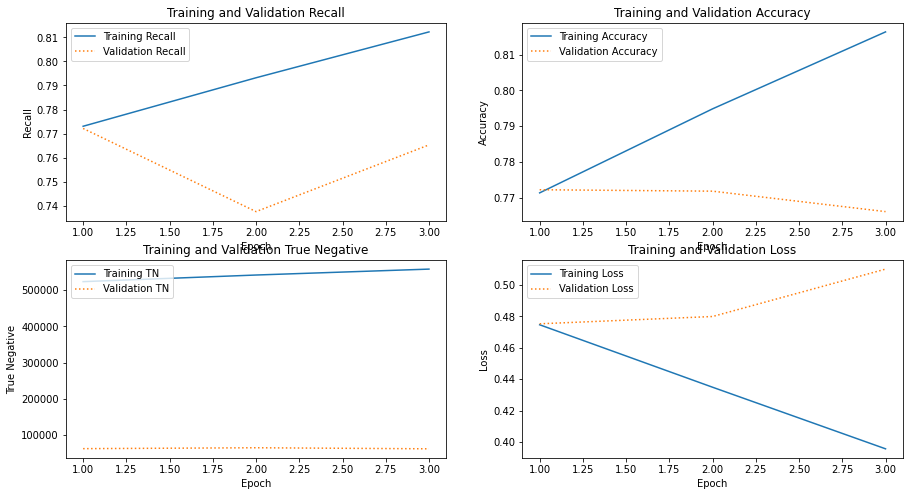


Matrice de confusion
--------------------
[[61895 18824]
 [17335 56550]]

Scores
--------------------
Accuracy : 0.7661185997774961
Recall : 0.7653786289503959
AUC : 0.7660872753022647


In [38]:
plot_keras_results(hist_spl.history, k_spl, X_test_padded, y_test)

In [39]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 187.71 secondes


*[(Retour sommaire)](#ch0)*

## <div id="ch3_2" style="color:orange">3.2 Keras : Modèle convolutionnel</div>

In [40]:
seed(11)

In [41]:
k_cnn = Sequential()
k_cnn.add(Embedding(TOP_WORDS, EMBEDDING_VECTOR_LENGTH, input_length=MAX_LEN))
k_cnn.add(Conv1D(EMBEDDING_VECTOR_LENGTH, 5, activation='relu'))  #Ligne spécifique CNN
k_cnn.add(MaxPooling1D(5))  #Ligne spécifique CNN
k_cnn.add(Flatten())
k_cnn.add(Dense(16, activation='relu'))
k_cnn.add(Dense(1, activation='sigmoid'))
k_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [42]:
k_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 256)           10240000  
                                                                 
 conv1d (Conv1D)             (None, 46, 256)           327936    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 256)           0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_2 (Dense)             (None, 16)                36880     
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                      

In [43]:
tps1 = time.time()
hist_cnn = k_cnn.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_cnn.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 103s 9ms/step - loss: 0.4708 - accuracy: 0.7749 - recall: 0.7836 - true_negatives: 581597.0000 - val_loss: 0.4705 - val_accuracy: 0.7765 - val_recall: 0.7807 - val_true_negatives: 62372.0000
Epoch 2/5
10625/10625 [==============================] - 95s 9ms/step - loss: 0.4214 - accuracy: 0.8055 - recall: 0.8147 - true_negatives: 541434.0000 - val_loss: 0.4764 - val_accuracy: 0.7730 - val_recall: 0.8090 - val_true_negatives: 59740.0000
Epoch 3/5
10625/10625 [==============================] - 99s 9ms/step - loss: 0.3684 - accuracy: 0.8361 - recall: 0.8415 - true_negatives: 564887.0000 - val_loss: 0.5094 - val_accuracy: 0.7700 - val_recall: 0.7474 - val_true_negatives: 63826.0000


Métriques
---------


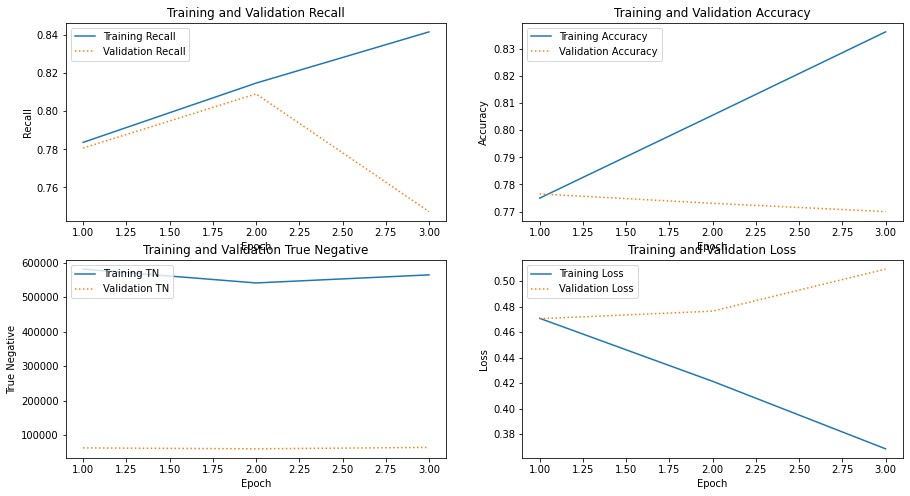


Matrice de confusion
--------------------
[[63826 16893]
 [18667 55218]]

Scores
--------------------
Accuracy : 0.7699930144110113
Recall : 0.7473506124382486
AUC : 0.7690345153272649


In [44]:
plot_keras_results(hist_cnn.history, k_cnn, X_test_padded, y_test)

In [45]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 296.6 secondes


*[(Retour sommaire)](#ch0)*

## <div id="ch3_3" style="color:orange">3.3 Keras : LSTM</div>

In [46]:
seed(11)

In [47]:
k_lstm = Sequential()
k_lstm.add(Embedding(TOP_WORDS, EMBEDDING_VECTOR_LENGTH, input_length=MAX_LEN))
k_lstm.add(LSTM(EMBEDDING_VECTOR_LENGTH))  #La couche LTSM remplace les couches Flatten() et Dense() du modèle simple
k_lstm.add(Dense(1, activation='sigmoid'))
k_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [48]:
k_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 256)           10240000  
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 10,765,569
Trainable params: 10,765,569
Non-trainable params: 0
_________________________________________________________________


In [49]:
tps1 = time.time()
hist_lstm = k_lstm.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_lstm.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 142s 13ms/step - loss: 0.6189 - accuracy: 0.6138 - recall: 0.6831 - true_negatives: 438777.0000 - val_loss: 0.4822 - val_accuracy: 0.7673 - val_recall: 0.7657 - val_true_negatives: 62050.0000
Epoch 2/5
10625/10625 [==============================] - 140s 13ms/step - loss: 0.4510 - accuracy: 0.7868 - recall: 0.7913 - true_negatives: 531989.0000 - val_loss: 0.4694 - val_accuracy: 0.7764 - val_recall: 0.8089 - val_true_negatives: 60264.0000
Epoch 3/5
10625/10625 [==============================] - 139s 13ms/step - loss: 0.4224 - accuracy: 0.8034 - recall: 0.8053 - true_negatives: 544975.0000 - val_loss: 0.4649 - val_accuracy: 0.7812 - val_recall: 0.7444 - val_true_negatives: 65779.0000
Epoch 4/5
10625/10625 [==============================] - 139s 13ms/step - loss: 0.3950 - accuracy: 0.8189 - recall: 0.8187 - true_negatives: 557005.0000 - val_loss: 0.4713 - val_accuracy: 0.7793 - val_recall: 0.7707 - val_true_negatives: 63536.0000
Epoc

Métriques
---------


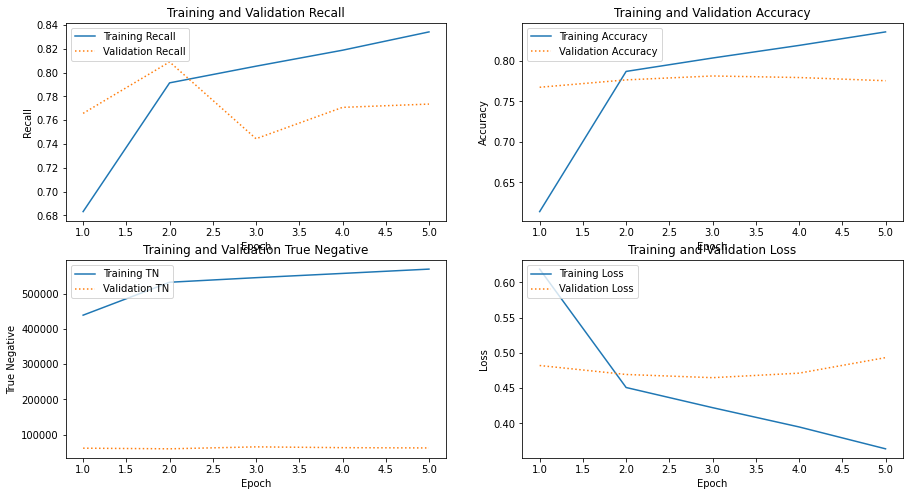


Matrice de confusion
--------------------
[[62723 17996]
 [16737 57148]]

Scores
--------------------
Accuracy : 0.7753421644976844
Recall : 0.7734722880151587
AUC : 0.7752630088101662


In [50]:
plot_keras_results(hist_lstm.history, k_lstm, X_test_padded, y_test)

In [51]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 699.92 secondes


*[(Retour sommaire)](#ch0)*

## <div id="ch3_4" style="color:orange">3.4 Keras : LSTM bidirectionnel</div>

In [52]:
seed(11)

In [53]:
k_bi = Sequential()
k_bi.add(Embedding(TOP_WORDS, EMBEDDING_VECTOR_LENGTH, input_length=MAX_LEN))
k_bi.add(Bidirectional(LSTM(EMBEDDING_VECTOR_LENGTH)))  #LTSM imbriqué dans une couche bidirectionnelle
k_bi.add(Dense(1, activation='sigmoid'))
k_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [54]:
k_bi.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 256)           10240000  
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1050624   
 l)                                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 11,291,137
Trainable params: 11,291,137
Non-trainable params: 0
_________________________________________________________________


In [55]:
tps1 = time.time()
hist_bi = k_bi.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_bi.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 230s 21ms/step - loss: 0.4647 - accuracy: 0.7778 - recall: 0.7823 - true_negatives: 587935.0000 - val_loss: 0.4653 - val_accuracy: 0.7794 - val_recall: 0.7468 - val_true_negatives: 65326.0000
Epoch 2/5
10625/10625 [==============================] - 226s 21ms/step - loss: 0.4253 - accuracy: 0.8012 - recall: 0.8047 - true_negatives: 542517.0000 - val_loss: 0.4618 - val_accuracy: 0.7829 - val_recall: 0.7717 - val_true_negatives: 64025.0000
Epoch 3/5
10625/10625 [==============================] - 224s 21ms/step - loss: 0.3943 - accuracy: 0.8191 - recall: 0.8208 - true_negatives: 555819.0000 - val_loss: 0.4728 - val_accuracy: 0.7807 - val_recall: 0.7426 - val_true_negatives: 65828.0000
Epoch 4/5
10625/10625 [==============================] - 225s 21ms/step - loss: 0.3582 - accuracy: 0.8387 - recall: 0.8388 - true_negatives: 570246.0000 - val_loss: 0.5015 - val_accuracy: 0.7748 - val_recall: 0.7578 - val_true_negatives: 63800.0000


Métriques
---------


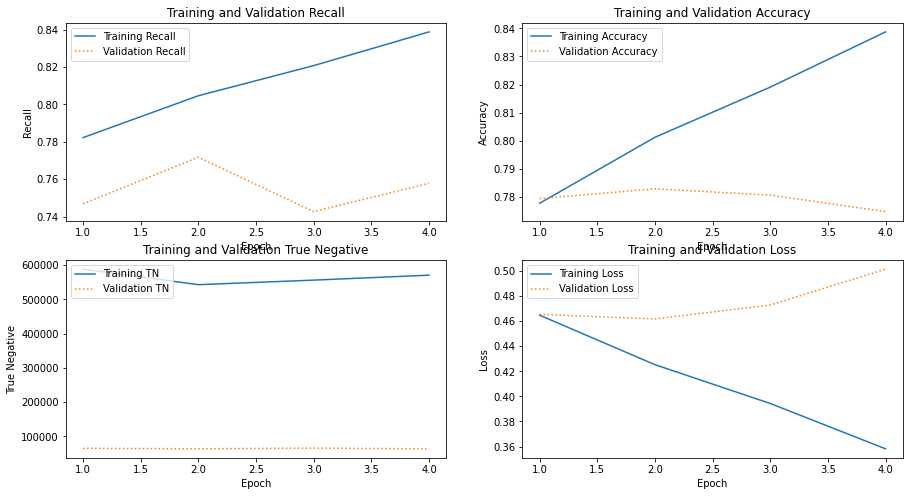


Matrice de confusion
--------------------
[[63800 16919]
 [17895 55990]]

Scores
--------------------
Accuracy : 0.7748182453235363
Recall : 0.7577992826690126
AUC : 0.7740977979023527


In [56]:
plot_keras_results(hist_bi.history, k_bi, X_test_padded, y_test)

In [57]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 904.16 secondes


*[(Retour sommaire)](#ch0)*

## <div id="ch3_5" style="color:orange">3.5 Keras : GRU bidirectionnel</div>

In [58]:
seed(11)

In [59]:
k_gru = Sequential()
k_gru.add(Embedding(TOP_WORDS, EMBEDDING_VECTOR_LENGTH, input_length=MAX_LEN))
k_gru.add(Bidirectional(GRU(EMBEDDING_VECTOR_LENGTH)))  #GRU imbriqué dans une couche bidirectionnelle
k_gru.add(Dense(1, activation='sigmoid'))
k_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [60]:
k_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 256)           10240000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 512)              789504    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 513       
                                                                 
Total params: 11,030,017
Trainable params: 11,030,017
Non-trainable params: 0
_________________________________________________________________


In [61]:
tps1 = time.time()
hist_gru = k_gru.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_gru.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 207s 19ms/step - loss: 0.4645 - accuracy: 0.7776 - recall: 0.7800 - true_negatives: 589327.0000 - val_loss: 0.4636 - val_accuracy: 0.7798 - val_recall: 0.7685 - val_true_negatives: 63784.0000
Epoch 2/5
10625/10625 [==============================] - 205s 19ms/step - loss: 0.4234 - accuracy: 0.8029 - recall: 0.8063 - true_negatives: 543671.0000 - val_loss: 0.4633 - val_accuracy: 0.7810 - val_recall: 0.8026 - val_true_negatives: 61439.0000
Epoch 3/5
10625/10625 [==============================] - 204s 19ms/step - loss: 0.3915 - accuracy: 0.8216 - recall: 0.8237 - true_negatives: 557241.0000 - val_loss: 0.4726 - val_accuracy: 0.7801 - val_recall: 0.7744 - val_true_negatives: 63390.0000
Epoch 4/5
10625/10625 [==============================] - 204s 19ms/step - loss: 0.3563 - accuracy: 0.8406 - recall: 0.8417 - true_negatives: 570935.0000 - val_loss: 0.5009 - val_accuracy: 0.7727 - val_recall: 0.7622 - val_true_negatives: 63143.0000


Métriques
---------


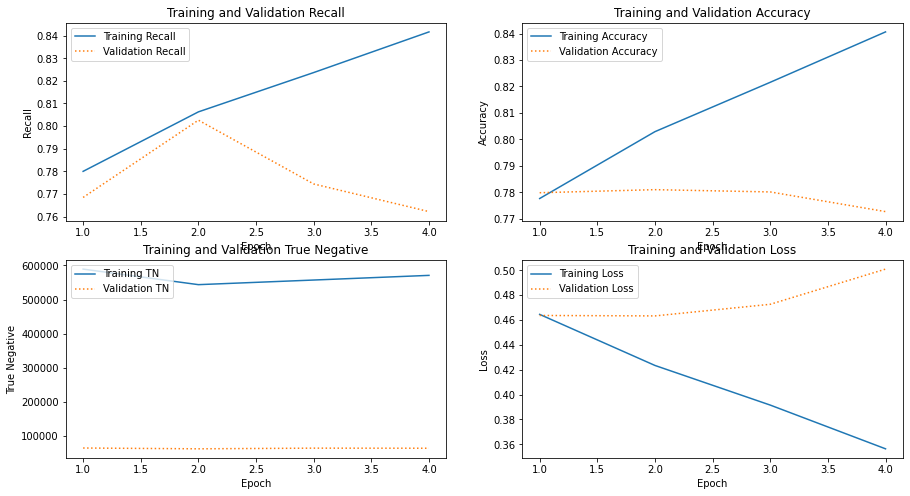


Matrice de confusion
--------------------
[[63143 17576]
 [17570 56315]]

Scores
--------------------
Accuracy : 0.7726708235233241
Recall : 0.7621980104216012
AUC : 0.7722274879719844


In [62]:
plot_keras_results(hist_gru.history, k_gru, X_test_padded, y_test)

In [63]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 820.03 secondes


*[(Retour sommaire)](#ch0)*

## <div id="ch3_6" style="color:orange">3.6 Keras : LSTM & Word Embedding pré-entraîné (GloVe)</div>

In [64]:
# Source : https://nlpforhackers.io/keras-intro/
def read_glove_vectors(path, length):
    embeddings = {}
    with open(path, encoding='utf-8') as glove_f:
        for line in glove_f:
            chunks = line.split()
            assert len(chunks) == length + 1
            embeddings[chunks[0]] = np.array(chunks[1:], dtype='float32')
    return embeddings

In [65]:
GLOVE_PATH = '/content/gdrive/MyDrive/Colab Notebooks/data/glove.6B/glove.6B.200d.txt'
GLOVE_VECTOR_LENGHT = 200

In [66]:
TOKENS = tokenizer.word_index

In [67]:
GLOVE_INDEX = read_glove_vectors(GLOVE_PATH, GLOVE_VECTOR_LENGHT)

In [68]:
embeddings_index = np.zeros((TOP_WORDS, GLOVE_VECTOR_LENGHT))
for word, idx in TOKENS.items():
    try:
        embedding = GLOVE_INDEX[word]
        embeddings_index[idx] = embedding
    except:
        pass

In [69]:
seed(11)

In [70]:
k_glo = Sequential()
k_glo.add(Embedding(TOP_WORDS, GLOVE_VECTOR_LENGHT, weights=[embeddings_index], input_length=MAX_LEN, trainable=False))
k_glo.add(LSTM(GLOVE_VECTOR_LENGHT))
k_glo.add(Dense(1, activation='sigmoid'))
k_glo.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [71]:
k_glo.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 200)           8000000   
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                                 
 dense_7 (Dense)             (None, 1)                 201       
                                                                 
Total params: 8,321,001
Trainable params: 321,001
Non-trainable params: 8,000,000
_________________________________________________________________


In [72]:
tps1 = time.time()
hist_glo = k_glo.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_glo.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 90s 8ms/step - loss: 0.5040 - accuracy: 0.7503 - recall: 0.7590 - true_negatives: 567616.0000 - val_loss: 0.5105 - val_accuracy: 0.7519 - val_recall: 0.7159 - val_true_negatives: 63352.0000
Epoch 2/5
10625/10625 [==============================] - 88s 8ms/step - loss: 0.4662 - accuracy: 0.7778 - recall: 0.7873 - true_negatives: 522447.0000 - val_loss: 0.4702 - val_accuracy: 0.7741 - val_recall: 0.7866 - val_true_negatives: 61570.0000
Epoch 3/5
10625/10625 [==============================] - 88s 8ms/step - loss: 0.4449 - accuracy: 0.7901 - recall: 0.7977 - true_negatives: 532111.0000 - val_loss: 0.4658 - val_accuracy: 0.7775 - val_recall: 0.7883 - val_true_negatives: 61959.0000
Epoch 4/5
10625/10625 [==============================] - 88s 8ms/step - loss: 0.4287 - accuracy: 0.7995 - recall: 0.8061 - true_negatives: 539154.0000 - val_loss: 0.4618 - val_accuracy: 0.7816 - val_recall: 0.8018 - val_true_negatives: 61606.0000
Epoch 5/5
10

Métriques
---------


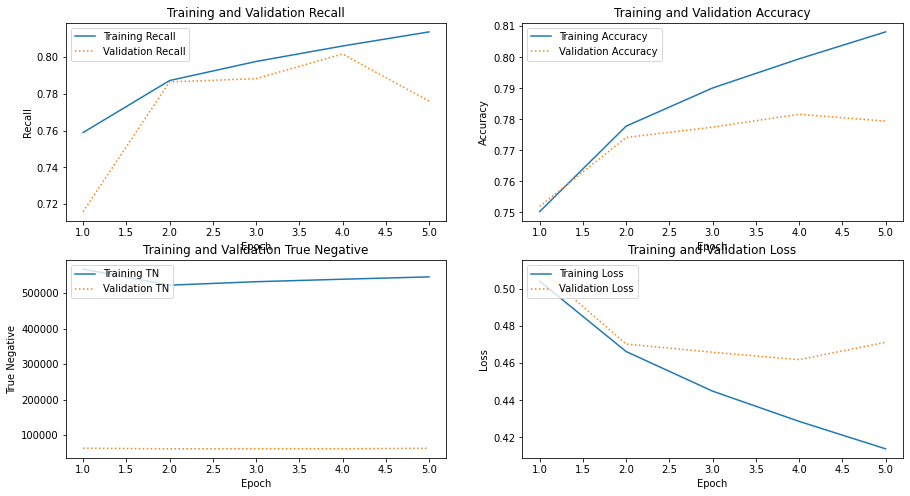


Matrice de confusion
--------------------
[[63161 17558]
 [16545 57340]]

Scores
--------------------
Accuracy : 0.7794170914077255
Recall : 0.7760709210259187
AUC : 0.7792754411866545


In [73]:
plot_keras_results(hist_glo.history, k_glo, X_test_padded, y_test)

In [74]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 439.44 secondes


*[(Retour sommaire)](#ch0)*

## <div id="ch3_7" style="color:orange">3.7 Keras : LSTM & Word Embedding pré-entraîné (FastText)</div>

In [75]:
from gensim.test.utils import datapath
from gensim.models import fasttext

In [76]:
import gensim

In [77]:
import codecs
from tqdm import tqdm

In [78]:
FASTTEXT_DIMS = 300

In [80]:
# Source: https://www.kaggle.com/code/vsmolyakov/keras-cnn-with-fasttext-embeddings/notebook
embeddings_index = {}
f = codecs.open('/content/gdrive/MyDrive/Colab Notebooks/data/fasttext/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

999995it [01:12, 13866.15it/s]

found 999995 word vectors


In [81]:
embedding_matrix = np.zeros((TOP_WORDS, FASTTEXT_DIMS))
for word, i in TOKENS.items():
    if i >= TOP_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [82]:
embedding_matrix.shape

(40000, 300)

In [83]:
seed(11)

In [84]:
k_fast = Sequential()
k_fast.add(Embedding(TOP_WORDS, FASTTEXT_DIMS, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False))
k_fast.add(LSTM(FASTTEXT_DIMS))
k_fast.add(Dense(1, activation='sigmoid'))
k_fast.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [85]:
k_fast.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 50, 300)           12000000  
                                                                 
 lstm_3 (LSTM)               (None, 300)               721200    
                                                                 
 dense_8 (Dense)             (None, 1)                 301       
                                                                 
Total params: 12,721,501
Trainable params: 721,501
Non-trainable params: 12,000,000
_________________________________________________________________


In [86]:
tps1 = time.time()
hist_fast = k_fast.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_fast.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 125s 12ms/step - loss: 0.4871 - accuracy: 0.7650 - recall: 0.7722 - true_negatives: 578682.0000 - val_loss: 0.4726 - val_accuracy: 0.7736 - val_recall: 0.7502 - val_true_negatives: 64166.0000
Epoch 2/5
10625/10625 [==============================] - 123s 12ms/step - loss: 0.4521 - accuracy: 0.7863 - recall: 0.7935 - true_negatives: 529762.0000 - val_loss: 0.4601 - val_accuracy: 0.7821 - val_recall: 0.7477 - val_true_negatives: 65675.0000
Epoch 3/5
10625/10625 [==============================] - 124s 12ms/step - loss: 0.4354 - accuracy: 0.7965 - recall: 0.8029 - true_negatives: 537285.0000 - val_loss: 0.4546 - val_accuracy: 0.7866 - val_recall: 0.7620 - val_true_negatives: 65318.0000
Epoch 4/5
10625/10625 [==============================] - 125s 12ms/step - loss: 0.4278 - accuracy: 0.8008 - recall: 0.8078 - true_negatives: 539713.0000 - val_loss: 0.4498 - val_accuracy: 0.7880 - val_recall: 0.7894 - val_true_negatives: 63506.0000
Epoc

Métriques
---------


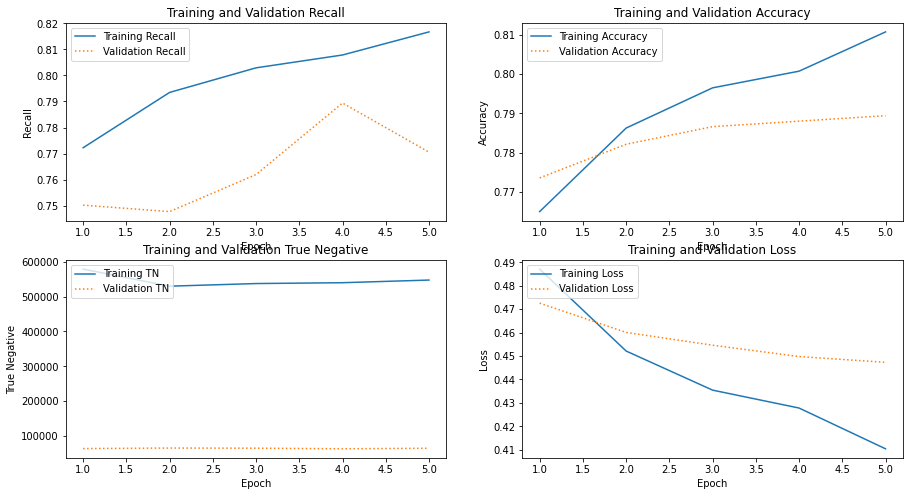


Matrice de confusion
--------------------
[[65116 15603]
 [16954 56931]]

Scores
--------------------
Accuracy : 0.7894168326822074
Recall : 0.7705352913311226
AUC : 0.7886175385036787


In [87]:
plot_keras_results(hist_fast.history, k_fast, X_test_padded, y_test)

In [88]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 623.33 secondes


*[(Retour sommaire)](#ch0)*

## <div id="ch3_8" style="color:orange">3.8 Keras : LSTM & Word Embedding pré-entraîné (GloVe) - sans normalisation</div>

In [12]:
def light_cleaning(s):
    s = re.sub('\@\w+', '', s) # Enlèvement des références à d'autres utilisateurs
    s = re.sub('http(s)?[:\/\.\w-]+', '', s) # Enlèvement des URL
    return s

In [13]:
tw_en['light_cleaned'] = tw_en['tw_text'].apply(light_cleaning)

In [14]:
tw_en = tw_en[tw_en['light_cleaned'].str.len() > 1]

In [39]:
print(f"Taille du jeu de données des séquences nettoyées > 1 : {tw_en.shape[0]}")

Taille du jeu de données des séquences nettoyées > 1 : 1519207


In [40]:
nb_pos = tw_en[tw_en['tw_y'] == 1].shape[0]
nb_neg = tw_en[tw_en['tw_y'] == 0].shape[0]
print(f"Nombre de lignes par classe : POS = {nb_pos} lignes :: NEG = {nb_neg} lignes")
print(f"Différence : {np.abs(nb_pos - nb_neg)} lignes en plus pour la classe {'POS' if nb_pos > nb_neg else 'NEG'}")

Nombre de lignes par classe : POS = 756318 lignes :: NEG = 762889 lignes
Différence : 6571 lignes en plus pour la classe NEG


In [16]:
tw_pos = tw_en.loc[tw_en['tw_y'] == 1, ['light_cleaned', 'tw_y']]
tw_neg = tw_en.loc[tw_en['tw_y'] == 0, ['light_cleaned', 'tw_y']]
tw_pos_train = tw_pos.head(680000)
tw_pos_test = tw_pos.tail(tw_pos.shape[0] - 680000)
tw_neg_train = tw_neg.head(680000)
tw_neg_test = tw_neg.tail(tw_neg.shape[0] - (680000))
X_train = np.concatenate((tw_pos_train['light_cleaned'], tw_neg_train['light_cleaned']))
X_test = np.concatenate((tw_pos_test['light_cleaned'], tw_neg_test['light_cleaned']))
y_train = np.concatenate((tw_pos_train['tw_y'], tw_neg_train['tw_y']))
y_test = np.concatenate((tw_pos_test['tw_y'], tw_neg_test['tw_y']))

In [42]:
print(f"Taille du jeu d'entraînement : X={np.shape(X_train)} y={np.shape(y_train)}")
print(f"Taille du jeu de test : X={np.shape(X_test)} y={np.shape(y_test)}")

Taille du jeu d'entraînement : X=(1360000,) y=(1360000,)
Taille du jeu de test : X=(159207,) y=(159207,)


In [17]:
def lc_length(s):
  return len(s.split())

In [18]:
tw_en['lc_lng'] = tw_en['light_cleaned'].apply(lc_length)

In [44]:
tw_en['lc_lng'].max()

64

In [19]:
MAX_LEN = tw_en['lc_lng'].max()  #Taille maximale des tweets du dataset
TOP_WORDS = 40000  #Taille du vocabulaire trouvée au chapitre précédent

In [47]:
tokenizer = Tokenizer(num_words=TOP_WORDS)
tokenizer.fit_on_texts(X_train)

In [59]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=MAX_LEN)
    return padded

In [60]:
X_train_padded = get_sequences(tokenizer, X_train)
X_test_padded = get_sequences(tokenizer, X_test)

In [50]:
TOKENS = tokenizer.word_index

In [51]:
GLOVE_INDEX = read_glove_vectors(GLOVE_PATH, GLOVE_VECTOR_LENGHT)

In [52]:
embeddings_index = np.zeros((TOP_WORDS, GLOVE_VECTOR_LENGHT))
for word, idx in TOKENS.items():
    try:
        embedding = GLOVE_INDEX[word]
        embeddings_index[idx] = embedding
    except:
        pass

In [53]:
seed(11)

In [57]:
k_glo_raw = Sequential()
k_glo_raw.add(Embedding(TOP_WORDS, GLOVE_VECTOR_LENGHT, weights=[embeddings_index], input_length=MAX_LEN, trainable=False))
k_glo_raw.add(Bidirectional(GRU(GLOVE_VECTOR_LENGHT)))
k_glo_raw.add(Dense(1, activation='sigmoid'))
k_glo_raw.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', rec, tn])

In [58]:
k_glo_raw.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 64, 200)           8000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 400)              482400    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 401       
                                                                 
Total params: 8,482,801
Trainable params: 482,801
Non-trainable params: 8,000,000
_________________________________________________________________


In [61]:
tps1 = time.time()
hist_glo_raw = k_glo_raw.fit(
    X_train_padded, y_train, validation_data=(X_test_padded, y_test), epochs=5, batch_size=128,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
               tf.keras.callbacks.ModelCheckpoint(
                   filepath='/content/gdrive/MyDrive/Colab Notebooks/data_colab/k_glo_raw.h5',
                   monitor='val_recall', mode='max', save_best_only=True)])
tps2 = time.time()

Epoch 1/5
10625/10625 [==============================] - 206s 19ms/step - loss: 0.4359 - accuracy: 0.7958 - recall: 0.7901 - true_negatives: 545009.0000 - val_loss: 0.4169 - val_accuracy: 0.8068 - val_recall: 0.7771 - val_true_negatives: 69147.0000
Epoch 2/5
10625/10625 [==============================] - 196s 18ms/step - loss: 0.3916 - accuracy: 0.8226 - recall: 0.8189 - true_negatives: 561873.0000 - val_loss: 0.4046 - val_accuracy: 0.8143 - val_recall: 0.8007 - val_true_negatives: 68527.0000
Epoch 3/5
10625/10625 [==============================] - 195s 18ms/step - loss: 0.3737 - accuracy: 0.8320 - recall: 0.8285 - true_negatives: 568053.0000 - val_loss: 0.4043 - val_accuracy: 0.8153 - val_recall: 0.7936 - val_true_negatives: 69230.0000
Epoch 4/5
10625/10625 [==============================] - 196s 18ms/step - loss: 0.3608 - accuracy: 0.8388 - recall: 0.8358 - true_negatives: 572467.0000 - val_loss: 0.4056 - val_accuracy: 0.8159 - val_recall: 0.8120 - val_true_negatives: 67922.0000
Epoc

Métriques
---------


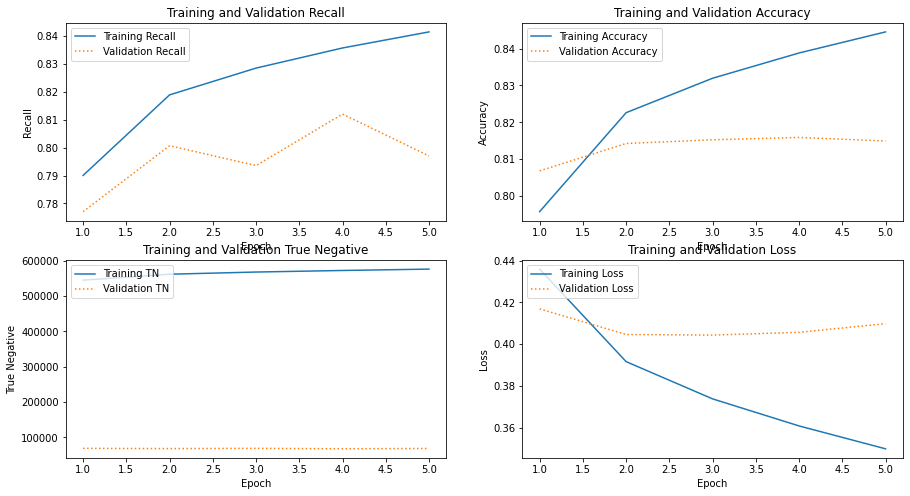


Matrice de confusion
--------------------
[[68914 13975]
 [15489 60829]]

Scores
--------------------
Accuracy : 0.8149327604941994
Recall : 0.7970465683062974


In [62]:
plot_keras_results(hist_glo_raw.history, k_glo_raw, X_test_padded, y_test)

In [63]:
print(f"Temps total d'exécution : {np.round(tps2 - tps1, 2)} secondes")

Temps total d'exécution : 1045.32 secondes


In [66]:
print(f'AUC : {roc_auc_score(y_test, k_glo_raw.predict(X_test_padded))}')

AUC : 0.896328291556162


*[(Retour sommaire)](#ch0)*

# <div id="ch4" style="color:blue">4 Transformers BERT</div>

## <div id="ch4_1" style="color:orange">4.1 BERT : DistilBERT</div>

In [15]:
%pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments

In [17]:
model_name = "distilbert-base-uncased"

In [18]:
# Source : https://www.youtube.com/watch?v=GSt00_-0ncQ
class BertDataset(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

In [19]:
b_dist_tok = DistilBertTokenizerFast.from_pretrained(model_name)

In [20]:
tw_pos = tw_en.loc[tw_en['tw_y'] == 1, ['light_cleaned', 'tw_y']]
tw_neg = tw_en.loc[tw_en['tw_y'] == 0, ['light_cleaned', 'tw_y']]
tw_pos_train = tw_pos.head(300000)
tw_pos_test = tw_pos.tail(50000)
tw_neg_train = tw_neg.head(300000)
tw_neg_test = tw_neg.tail(50000)
X_train = np.concatenate((tw_pos_train['light_cleaned'], tw_neg_train['light_cleaned']))
X_test = np.concatenate((tw_pos_test['light_cleaned'], tw_neg_test['light_cleaned']))
y_train = np.concatenate((tw_pos_train['tw_y'], tw_neg_train['tw_y']))
y_test = np.concatenate((tw_pos_test['tw_y'], tw_neg_test['tw_y']))

In [21]:
print(f"Taille du jeu d'entraînement : X={np.shape(X_train)} y={np.shape(y_train)}")
print(f"Taille du jeu de test : X={np.shape(X_test)} y={np.shape(y_test)}")

Taille du jeu d'entraînement : X=(600000,) y=(600000,)
Taille du jeu de test : X=(100000,) y=(100000,)


In [22]:
def lc_length(s):
  return len(s.split())

In [23]:
tw_en['lc_lng'] = tw_en['light_cleaned'].apply(lc_length)

In [24]:
tw_en['lc_lng'].max()

64

In [25]:
MAX_LEN = tw_en['lc_lng'].max()  #Taille maximale des tweets du dataset
TOP_WORDS = 40000  #Taille du vocabulaire trouvée au chapitre précédent

In [26]:
X_train_padded = b_dist_tok(list(np.array(X_train)), padding=True, truncation=True)
X_test_padded = b_dist_tok(list(np.array(X_test)), padding=True, truncation=True)

In [27]:
X_train_ds = BertDataset(X_train_padded, y_train)
X_test_ds = BertDataset(X_test_padded, y_test)

In [29]:
training_args = TrainingArguments(
    seed=11,
    output_dir='/content/bert',
    save_total_limit=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

In [30]:
b_dist = DistilBertForSequenceClassification.from_pretrained(model_name)

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

In [31]:
trainer = Trainer(
    model=b_dist,
    args=training_args,
    train_dataset=X_train_ds,
    eval_dataset=X_test_ds
)

In [32]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 600000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 112500


Epoch,Training Loss,Validation Loss
1,0.358400,0.364949
2,0.305400,0.354038
3,0.231900,0.442058


***** Running Evaluation *****
  Num examples = 100000
  Batch size = 16
Saving model checkpoint to /content/bert/checkpoint-37500
Configuration saved in /content/bert/checkpoint-37500/config.json
Model weights saved in /content/bert/checkpoint-37500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 100000
  Batch size = 16
Saving model checkpoint to /content/bert/checkpoint-75000
Configuration saved in /content/bert/checkpoint-75000/config.json
Model weights saved in /content/bert/checkpoint-75000/pytorch_model.bin
Deleting older checkpoint [/content/bert/checkpoint-37500] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 100000
  Batch size = 16
Saving model checkpoint to /content/bert/checkpoint-112500
Configuration saved in /content/bert/checkpoint-112500/config.json
Model weights saved in /content/bert/checkpoint-112500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best mod

TrainOutput(global_step=112500, training_loss=0.3036887846544054, metrics={'train_runtime': 13057.7939, 'train_samples_per_second': 137.849, 'train_steps_per_second': 8.616, 'total_flos': 5.49532724112e+16, 'train_loss': 0.3036887846544054, 'epoch': 3.0})

In [33]:
from huggingface_hub import notebook_login

In [34]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [35]:
from huggingface_hub import create_repo
create_repo("tatsumaru/bert")

'https://huggingface.co/tatsumaru/bert'

In [37]:
from huggingface_hub import Repository
repo = Repository(local_dir="d_bert", clone_from="https://huggingface.co/tatsumaru/bert")

Cloning https://huggingface.co/tatsumaru/bert into local empty directory.


In [38]:
with repo.commit('d_bert'):
  b_dist.save_pretrained('b_dist')
  b_dist_tok.save_pretrained('b_dist_tok')

Pulling changes ...
Configuration saved in b_dist/config.json
Model weights saved in b_dist/pytorch_model.bin
tokenizer config file saved in b_dist_tok/tokenizer_config.json
Special tokens file saved in b_dist_tok/special_tokens_map.json


Upload file b_dist/pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

To https://huggingface.co/tatsumaru/bert
   6248b7d..ede8d82  main -> main



In [42]:
with repo.commit('trainer'):
  trainer.save_model('b_dist_trainer')

Pulling changes ...
Saving model checkpoint to b_dist_trainer
Configuration saved in b_dist_trainer/config.json
Model weights saved in b_dist_trainer/pytorch_model.bin


Upload file b_dist_trainer/training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

To https://huggingface.co/tatsumaru/bert
   ede8d82..1839370  main -> main



In [43]:
y_pred_bert = trainer.predict(X_test_ds)

***** Running Prediction *****
  Num examples = 100000
  Batch size = 16


In [50]:
y_pred = []
for y in y_pred_bert.predictions:
  y_pred.append(np.argmax(y))

In [53]:
confusion_matrix(y_test, y_pred)

array([[43232,  6768],
       [ 7970, 42030]])

In [52]:
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"AUC : {roc_auc_score(y_test, y_pred)}")

Accuracy : 0.85262
Recall : 0.8406
AUC : 0.85262


*[(Retour sommaire)](#ch0)*

## <div id="ch4_2" style="color:orange">4.2 BERT : BERTweet</div>

In [55]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [54]:
model_name = "vinai/bertweet-base"

In [56]:
b_tweet_tok = AutoTokenizer.from_pretrained(model_name)

Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/vinai/bertweet-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpfonjapug


Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
creating metadata file for /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "h

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
creating metadata file for /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpk9jveerz


Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes in cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
creating metadata file for /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/9a877d0d57efbfeae96fec396a35595dc8c4685fe2b7b2049c6c094e24a0e8bf.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/vinai/bertweet-base/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/1c2d05a06ac61a063ad62a7590731a28cc62f58e2802c76b5f993165f25894a9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
loading file https://huggingf

In [58]:
tw_pos = tw_en.loc[tw_en['tw_y'] == 1, ['tw_text', 'tw_y']]
tw_neg = tw_en.loc[tw_en['tw_y'] == 0, ['tw_text', 'tw_y']]
tw_pos_train = tw_pos.head(300000)
tw_pos_test = tw_pos.tail(50000)
tw_neg_train = tw_neg.head(300000)
tw_neg_test = tw_neg.tail(50000)
X_train = np.concatenate((tw_pos_train['tw_text'], tw_neg_train['tw_text']))
X_test = np.concatenate((tw_pos_test['tw_text'], tw_neg_test['tw_text']))
y_train = np.concatenate((tw_pos_train['tw_y'], tw_neg_train['tw_y']))
y_test = np.concatenate((tw_pos_test['tw_y'], tw_neg_test['tw_y']))

In [59]:
print(f"Taille du jeu d'entraînement : X={np.shape(X_train)} y={np.shape(y_train)}")
print(f"Taille du jeu de test : X={np.shape(X_test)} y={np.shape(y_test)}")

Taille du jeu d'entraînement : X=(600000,) y=(600000,)
Taille du jeu de test : X=(100000,) y=(100000,)


In [60]:
tw_en['tw_lng'] = tw_en['tw_text'].apply(lc_length)

In [62]:
tw_en['tw_lng'].max()

64

In [63]:
MAX_LEN = tw_en['tw_lng'].max()  #Taille maximale des tweets du dataset
TOP_WORDS = 40000  #Taille du vocabulaire trouvée au chapitre précédent

In [64]:
X_train_padded = b_tweet_tok(list(np.array(X_train)), padding=True, truncation=True)
X_test_padded = b_tweet_tok(list(np.array(X_test)), padding=True, truncation=True)

In [67]:
X_train_ds = BertDataset(X_train_padded, y_train)
X_test_ds = BertDataset(X_test_padded, y_test)

In [68]:
training_args = TrainingArguments(
    seed=11,
    output_dir='/content/bertweet',
    save_total_limit=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [69]:
b_tweet = AutoModelForSequenceClassification.from_pretrained(model_name)

loading configuration file https://huggingface.co/vinai/bertweet-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/356366feedcea0917e30f7f235e1e062ffc2d28138445d5672a184be756c8686.a2b6026e688d1b19cebc0981d8f3a5b1668eabfda55b2c42049d5eac0bc8cb2d
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.20.1",
  "type_vocab_size": 1,
  "use_cache"

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

storing https://huggingface.co/vinai/bertweet-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/4e07e2989cb95a6f63c704a7170b48e6e663cc203c05db424e47f4d75562cf0e.7b2adda243ecb4b085eb2d22ef1b2cd12a882a43bbb13a34c11e10f960b9bfc3
creating metadata file for /root/.cache/huggingface/transformers/4e07e2989cb95a6f63c704a7170b48e6e663cc203c05db424e47f4d75562cf0e.7b2adda243ecb4b085eb2d22ef1b2cd12a882a43bbb13a34c11e10f960b9bfc3
loading weights file https://huggingface.co/vinai/bertweet-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/4e07e2989cb95a6f63c704a7170b48e6e663cc203c05db424e47f4d75562cf0e.7b2adda243ecb4b085eb2d22ef1b2cd12a882a43bbb13a34c11e10f960b9bfc3
Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.

In [70]:
trainer = Trainer(
    model=b_tweet,
    args=training_args,
    train_dataset=X_train_ds,
    eval_dataset=X_test_ds
)

In [71]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 600000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 112500


Epoch,Training Loss,Validation Loss
1,0.440400,0.417299
2,0.356900,0.354568


***** Running Evaluation *****
  Num examples = 100000
  Batch size = 16
Saving model checkpoint to /content/bertweet/checkpoint-37500
Configuration saved in /content/bertweet/checkpoint-37500/config.json
Model weights saved in /content/bertweet/checkpoint-37500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 100000
  Batch size = 16
Saving model checkpoint to /content/bertweet/checkpoint-75000
Configuration saved in /content/bertweet/checkpoint-75000/config.json
Model weights saved in /content/bertweet/checkpoint-75000/pytorch_model.bin
Deleting older checkpoint [/content/bertweet/checkpoint-37500] due to args.save_total_limit


Epoch,Training Loss,Validation Loss
1,0.440400,0.417299
2,0.356900,0.354568
3,0.290300,0.351017


***** Running Evaluation *****
  Num examples = 100000
  Batch size = 16
Saving model checkpoint to /content/bertweet/checkpoint-112500
Configuration saved in /content/bertweet/checkpoint-112500/config.json
Model weights saved in /content/bertweet/checkpoint-112500/pytorch_model.bin
Deleting older checkpoint [/content/bertweet/checkpoint-75000] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/bertweet/checkpoint-112500 (score: 0.3510168790817261).


TrainOutput(global_step=112500, training_loss=0.35671465372721356, metrics={'train_runtime': 25169.3581, 'train_samples_per_second': 71.516, 'train_steps_per_second': 4.47, 'total_flos': 1.09149976872e+17, 'train_loss': 0.35671465372721356, 'epoch': 3.0})

In [72]:
create_repo("tatsumaru/bertweet")

'https://huggingface.co/tatsumaru/bertweet'

In [73]:
repo = Repository(local_dir="t_bert", clone_from="https://huggingface.co/tatsumaru/bertweet")

Cloning https://huggingface.co/tatsumaru/bertweet into local empty directory.


In [74]:
with repo.commit('t_bert'):
  b_dist.save_pretrained('b_tweet')
  b_dist_tok.save_pretrained('b_tweet_tok')
  trainer.save_model('b_tweet_trainer')

Pulling changes ...
Configuration saved in b_tweet/config.json
Model weights saved in b_tweet/pytorch_model.bin
tokenizer config file saved in b_tweet_tok/tokenizer_config.json
Special tokens file saved in b_tweet_tok/special_tokens_map.json
Saving model checkpoint to b_tweet_trainer
Configuration saved in b_tweet_trainer/config.json
Model weights saved in b_tweet_trainer/pytorch_model.bin


Upload file b_tweet_trainer/pytorch_model.bin:   0%|          | 3.34k/515M [00:00<?, ?B/s]

Upload file b_tweet_trainer/training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Upload file b_tweet/pytorch_model.bin:   0%|          | 3.34k/255M [00:00<?, ?B/s]

To https://huggingface.co/tatsumaru/bertweet
   20e6bb3..e454b0e  main -> main



In [75]:
y_pred_bert = trainer.predict(X_test_ds)

***** Running Prediction *****
  Num examples = 100000
  Batch size = 16


In [76]:
y_pred = []
for y in y_pred_bert.predictions:
  y_pred.append(np.argmax(y))

In [77]:
confusion_matrix(y_test, y_pred)

array([[43660,  6340],
       [ 7497, 42503]])

In [78]:
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(f"Recall : {recall_score(y_test, y_pred)}")
print(f"AUC : {roc_auc_score(y_test, y_pred)}")

Accuracy : 0.86163
Recall : 0.85006
AUC : 0.86163


*[(Retour sommaire)](#ch0)*